In [ ]:
import os
from google.cloud import bigquery as bq
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

service_account_path = '/home/yusuf/DataScience/dream_games/ybektas20.json'
client = bq.Client.from_service_account_json(service_account_path)
ab_shape_query = """
-- Get the shape (row and column counts) for AB test tables
WITH row_counts AS (
  SELECT 'q2_table_ab_test_enter' AS table_name, 
         (SELECT COUNT(*) FROM `casedreamgames.case_db.q2_table_ab_test_enter`) AS row_count
  UNION ALL
  SELECT 'q2_table_ab_test_revenue' AS table_name, 
         (SELECT COUNT(*) FROM `casedreamgames.case_db.q2_table_ab_test_revenue`) AS row_count
  UNION ALL
  SELECT 'q2_table_ab_test_session' AS table_name, 
         (SELECT COUNT(*) FROM `casedreamgames.case_db.q2_table_ab_test_session`) AS row_count
),
column_counts AS (
  SELECT table_name, COUNT(*) AS column_count
  FROM `casedreamgames.case_db.INFORMATION_SCHEMA.COLUMNS`
  WHERE table_name IN ('q2_table_ab_test_enter', 'q2_table_ab_test_revenue', 'q2_table_ab_test_session')
  GROUP BY table_name
)
SELECT r.table_name, r.row_count, c.column_count
FROM row_counts r
JOIN column_counts c ON r.table_name = c.table_name;
"""
ab_shape = client.query(ab_shape_query).result().to_dataframe()
print("Shape of AB Test Tables:")
print(ab_shape)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Shape of AB Test Tables:
                 table_name  row_count  column_count
0    q2_table_ab_test_enter      73450             5
1  q2_table_ab_test_session  224144299             5
2  q2_table_ab_test_revenue      74929             6


In [15]:
# Query to get per-user revenue (ARPU) for the AB test
user_revenue_query = """
SELECT 
  a.user_id,
  a.group_id,
  COALESCE(SUM(CAST(r.dollar_amount AS FLOAT64)), 0) AS revenue
FROM `casedreamgames.case_db.q2_table_ab_test_enter` a
LEFT JOIN `casedreamgames.case_db.q2_table_ab_test_revenue` r
  ON a.user_id = r.user_id
GROUP BY a.user_id, a.group_id
"""
ab_user_revenue = client.query(user_revenue_query).result().to_dataframe()
print("Per-user Revenue DataFrame:")
print(ab_user_revenue.head())

# Separate revenue data by group
group_A_revenue = ab_user_revenue[ab_user_revenue['group_id'] == 'A']['revenue']
group_B_revenue = ab_user_revenue[ab_user_revenue['group_id'] == 'B']['revenue']

# Perform t-test on ARPU between groups
from scipy import stats
t_stat_arpu, p_val_arpu = stats.ttest_ind(group_A_revenue, group_B_revenue, equal_var=False)
print("\nT-test for ARPU:")
print("t-statistic =", t_stat_arpu, "p-value =", p_val_arpu)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Per-user Revenue DataFrame:
             user_id group_id  revenue
0  txlqw6185177497a2        A      0.0
1  txlqw6185791752a2        A      0.0
2  txlqw6187363919a2        A      0.0
3  txlqw6186918784a2        A      0.0
4  txlqw6186405215a2        A      0.0

T-test for ARPU:
t-statistic = -2.9891326045019815 p-value = 0.002798791152997717


<Axes: title={'center': 'Average Revenue per User by Group'}, xlabel='group_id'>

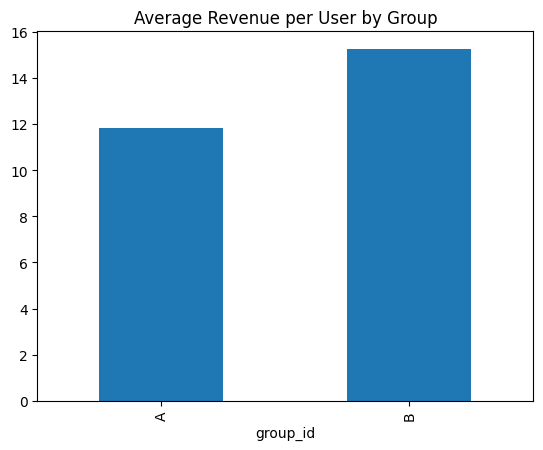

In [22]:
ab_user_revenue.groupby('group_id')['revenue'].mean().plot(kind='bar', title='Average Revenue per User by Group')

In [20]:
# Query to get conversion flag per user (1 if revenue > 0, else 0)
conversion_query = """
SELECT 
  a.user_id,
  a.group_id,
  CASE 
    WHEN COALESCE(SUM(CAST(r.dollar_amount AS FLOAT64)), 0) > 0 THEN 1 
    ELSE 0 
  END AS converted
FROM `casedreamgames.case_db.q2_table_ab_test_enter` a
LEFT JOIN `casedreamgames.case_db.q2_table_ab_test_revenue` r
  ON a.user_id = r.user_id
GROUP BY a.user_id, a.group_id
"""
ab_conversion = client.query(conversion_query).result().to_dataframe()
print("\nConversion DataFrame:")
print(ab_conversion.head())

# Aggregate conversion counts by group
conv_summary = ab_conversion.groupby('group_id').agg(
    total_users=('user_id', 'nunique'),
    converters=('converted', 'sum')
).reset_index()
print("\nConversion Summary by Group:")
print(conv_summary)

# Use proportions_ztest for conversion rate difference
from statsmodels.stats.proportion import proportions_ztest
count = conv_summary['converters'].values
nobs = conv_summary['total_users'].values
z_stat, p_val_conv = proportions_ztest(count, nobs)
print("\nProportions Z-test for Conversion Rate:")
print("z-statistic =", z_stat, "p-value =", p_val_conv)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Conversion DataFrame:
             user_id group_id  converted
0  txlqw6185177497a2        A          0
1  txlqw6185791752a2        A          0
2  txlqw6187363919a2        A          0
3  txlqw6186918784a2        A          0
4  txlqw6186405215a2        A          0

Conversion Summary by Group:
  group_id  total_users  converters
0        A        37188        2782
1        B        36262        3261

Proportions Z-test for Conversion Rate:
z-statistic = -7.455721218299171 p-value = 8.937755283786538e-14


<Axes: title={'center': 'Conversion Rate by Group'}, xlabel='group_id'>

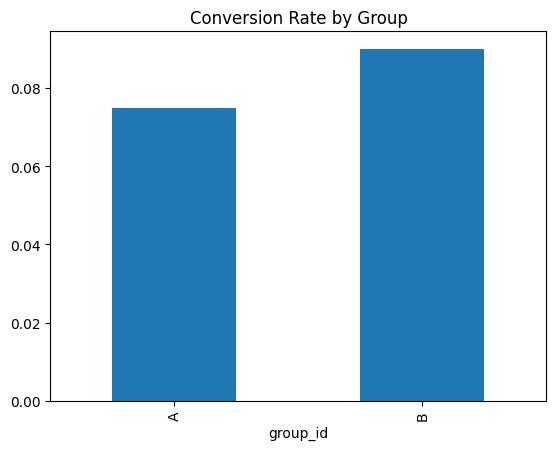

In [ ]:
ab_conversion.groupby('group_id')['converted'].mean().plot(kind='bar', title='Conversion Rate by Group')

In [21]:
# Query to get average session duration per user along with group information
session_duration_query = """
SELECT
  a.user_id,
  a.group_id,
  AVG(s.time_spent) AS avg_session_duration
FROM `casedreamgames.case_db.q2_table_ab_test_enter` a
JOIN `casedreamgames.case_db.q2_table_ab_test_session` s
  ON a.user_id = s.user_id
GROUP BY a.user_id, a.group_id
"""
ab_session_duration = client.query(session_duration_query).result().to_dataframe()
print("\nSession Duration DataFrame:")
print(ab_session_duration.head())

# Separate session duration data by group
group_A_duration = ab_session_duration[ab_session_duration['group_id'] == 'A']['avg_session_duration']
group_B_duration = ab_session_duration[ab_session_duration['group_id'] == 'B']['avg_session_duration']

# Perform t-test on average session duration
t_stat_duration, p_val_duration = stats.ttest_ind(group_A_duration, group_B_duration, equal_var=False)
print("\nT-test for Average Session Duration:")
print("t-statistic =", t_stat_duration, "p-value =", p_val_duration)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Session Duration DataFrame:
             user_id group_id  avg_session_duration
0  txlqw6184685673a2        A             29.157792
1  txlqw6184687464a2        A             28.659529
2  txlqw6184689990a2        A             29.255713
3  txlqw6184691081a2        A             28.051414
4  txlqw6184698455a2        A             28.430380

T-test for Average Session Duration:
t-statistic = 1.4122732799423077 p-value = 0.15787376234645648


<Axes: title={'center': 'Average Session Duration by Group'}, xlabel='group_id'>

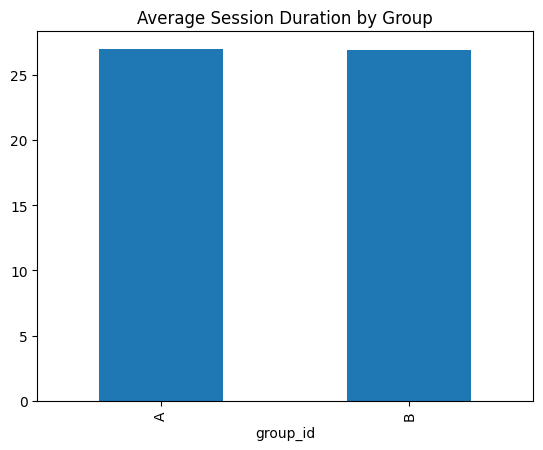

In [24]:
ab_session_duration.groupby('group_id')['avg_session_duration'].mean().plot(kind='bar', title='Average Session Duration by Group')